## Sequence-to-sequence
**Yamil Ernesto Morfa Avalos**

En este trabajo implementaremos el modelo Sequence-to-sequence (Seq2Seq). Este en terminos simples es un modelo que se entrena para convertir una sequencia de un dominio (por ejemplo frases en ingles) a una sequencia en otro dominio (frases en español) 

Descargemos y acomodemos los datos para el trabajo

In [ ]:
!wget -O en-es.txt.zip http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-es.txt.zip
!unzip en-es.txt.zip
!rm en-es.txt.zip
!rm OpenSubtitles.en-es.ids



--2021-06-17 23:04:28--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-es.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-es.txt.zip [following]
--2021-06-17 23:04:30--  https://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-es.txt.zip
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-es.txt.zip [following]
--2021-06-17 23:04:31--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-es.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

Echemos un vistazo a los datos

In [ ]:
!head -10 OpenSubtitles.en-es.en

The Loner
You love curry, right?
I'll give you more.
Hey!
Is it good?
Hey, ugly.
Look at her.
- Crazy bitch.
- I asked you a question!
That's better!


In [ ]:
!head -10 OpenSubtitles.en-es.es

La Solitaria
Te encanta el curry, ¿no?
Te pondré más.
¡Eh!
¿Está bueno?
Eh, fea.
Miradla.
- Puta loca.
- ¡Te he preguntado!
¡Así estás mejor!


Arriba puede ver las primeras 10 líneas de frases en EN y ES. Podemos ver que la traducción es correcta.

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np

es_file = open('./OpenSubtitles.en-es.es', 'r')
en_file = open('./OpenSubtitles.en-es.en', 'r')

dataset = {'en': [],'es': []}

total_lines = 5000
for i in tqdm(range(total_lines), total=total_lines):
    es_text = es_file.readline()
    en_text = en_file.readline()

    if not en_text and not es_text:
        # one of file is finished
        break

    es_text = es_text.strip()
    en_text = en_text.strip()
    if not en_text or not es_text:
        continue

    dataset['es'].append(es_text)
    dataset['en'].append(en_text)
    
es_file, en_file = None, None

del es_file
del en_file

df = pd.DataFrame(dataset)
df.head(10)

100%|██████████| 5000/5000 [00:00<00:00, 494133.50it/s]


,en,es
0,The Loner,La Solitaria
1,"You love curry, right?","Te encanta el curry, ¿no?"
2,I'll give you more.,Te pondré más.
3,Hey!,¡Eh!
4,Is it good?,¿Está bueno?
5,"Hey, ugly.","Eh, fea."
6,Look at her.,Miradla.
7,- Crazy bitch.,- Puta loca.
8,- I asked you a question!,- ¡Te he preguntado!
9,That's better!,¡Así estás mejor!


In [ ]:
df.index.values.max()

4999

Agregamos a las oraciones en Español 'START_ ' y '_END'. La razón de esto es que nuestro modelo distinga cuándo comienza y termina la oración. También creamos el vocabulario de todas las palabras en español e inglés.

In [ ]:
df.es = df.es.apply(lambda x : 'START_ '+ x + ' _END') ## agrgar 'START_' y '_END' a cada frase

In [ ]:
df.head(5)

,en,es
0,The Loner,START_ La Solitaria _END
1,"You love curry, right?","START_ Te encanta el curry, ¿no? _END"
2,I'll give you more.,START_ Te pondré más. _END
3,Hey!,START_ ¡Eh! _END
4,Is it good?,START_ ¿Está bueno? _END


In [ ]:
df.es[df.sample().index.values[0]].split()

['START_',
 '-',
 'Creo...',
 'que',
 'sólo',
 'está',
 'fingiendo',
 'ser',
 'retrasada.',
 '_END']

Ahora construyamos los conjuntos **input_words** y **target_words** con todas la palabras que aparecen en las frases de ingles y su traducción al español respectivamente.

In [ ]:
lenght_en = [] ## lista de cantidades de palabras por frase en ingles 
all_en_words=set() ## conjunto de todas las palabras en ingles
for en in df.en:
  count = 0
  for word in en.split():
    count +=1 
    if word not in all_en_words: ## No repetir palabras
      all_en_words.add(word)
  lenght_en.append(count)    


lenght_es = [] ## lista de cantidad de palabras por frase en español   
all_es_words=set() ## conjunto de todas las palabras en español
for es in df.es:
  count = 0
  for word in es.split():
    count +=1 
    if word not in all_es_words:
      all_es_words.add(word)
  lenght_es.append(count)


input_words = sorted(list(all_en_words))
target_words = sorted(list(all_es_words))

num_encoder_tokens = len(all_en_words) ## número de palabras en Ingles
num_decoder_tokens = len(all_es_words) ## número de palabras en español 

## número maximo de palabras por frase en cada idioma
max_lenght_en = np.max(lenght_en) 
max_lenght_es = np.max(lenght_es)

Codificamos cada token (palabra) como un entero. A cada palabra le asignamos un valor diferente. Esto paara cada sequencia.

In [ ]:
input_token_index  = dict([(words, i) for i, words in enumerate(input_words)])
target_token_index = dict([(words, i) for i, words in enumerate(target_words)])

In [ ]:
print(f'Número de palabras en el idioma fuente (Ingles): {num_encoder_tokens}')
print(f'Número de palabras en el idioma objetivo (Español): {num_decoder_tokens}')

Número de palabras en el idioma fuente (Ingles): 8464
Número de palabras en el idioma objetivo (Español): 9544


In [ ]:
print('Número máxima de palabras por frase en el idioma fuente:', max_lenght_en)
print('Numero máxima de palabras por frase en el idioma destino:', max_lenght_es)

Número máxima de palabras por frase en el idioma fuente: 55
Numero máxima de palabras por frase en el idioma destino: 55


In [ ]:
print(f'Muestras del conjunto (Set) de palabras que conforman las sentencias de entrada: \n{input_words[0:15]} ')
print(f'{input_words[15:25]} \n')
    
print(f'\n Muestras del conjunto (Set) de palabras que conforman las sentencias objetivo: \n{target_words[0:15]}')
print(f'{target_words[15:25]} \n')

Muestras del conjunto (Set) de palabras que conforman las sentencias de entrada: 
['!', '"', '"0n', '"0ne', '"A', '"All', '"Am', '"And', '"At', '"Black', '"But', '"By', '"Come', '"Conquista".', '"Conquistadors".'] 
['"Cross', '"Dance."', '"Don\'t', '"El', '"Few', '"Firstly,', '"For', '"Friends', '"Give', '"He'] 


 Muestras del conjunto (Set) de palabras que conforman las sentencias objetivo: 
['!', '"', '"1', '"245-3,', '"A', '"Acá,', '"Al', '"Amigos', '"Amor', '"Aseguraos', '"Atravesamos', '"Aunque', '"Bailen".', '"Blanco', '"Bueno,']
['"Como', '"Compartimos', '"Con', '"Cuando', '"De', '"Deseo', '"Durante', '"Eh,', '"El', '"En'] 



Los datos de entrada del codificador **encoder_input_data** serán  arreglos de $\left(num\_frases, max\_leght\_en\right)$ que reprecentan cada frase en inglés mediante un índice de palabras en el vocabulario. 

Análogamente los datos de entrada del decodificador **decoder_input_data** serán arreglos de  $\left(num\_frases, max\_leght\_es\right)$ que reprecentan un índice de palabras en español. 

**decoder_target_data** será un arreglo tridimensional de $\left(num\_frases,\, max\_lenght\_es,\, num\_decoder\_tokens\right)$ de $0$ y $1$

In [ ]:
encoder_input_data = np.zeros(
    (len(df.en), max_lenght_en),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(df.es), max_lenght_es),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(df.es), max_lenght_es, num_decoder_tokens),
    dtype='float32')

# generar datos
for i, (input_text, target_text) in enumerate(zip(df.en, df.es)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

La implementación sigue como la vista en clases

In [ ]:
embedding_size = 1024 ## espacio latente

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model

encoder_inputs = Input(shape=(None,))


en_x=  Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)


encoder = LSTM(embedding_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))

dex=  Embedding(num_decoder_tokens, embedding_size)
final_dex= dex(decoder_inputs)

decoder_lstm = LSTM(embedding_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

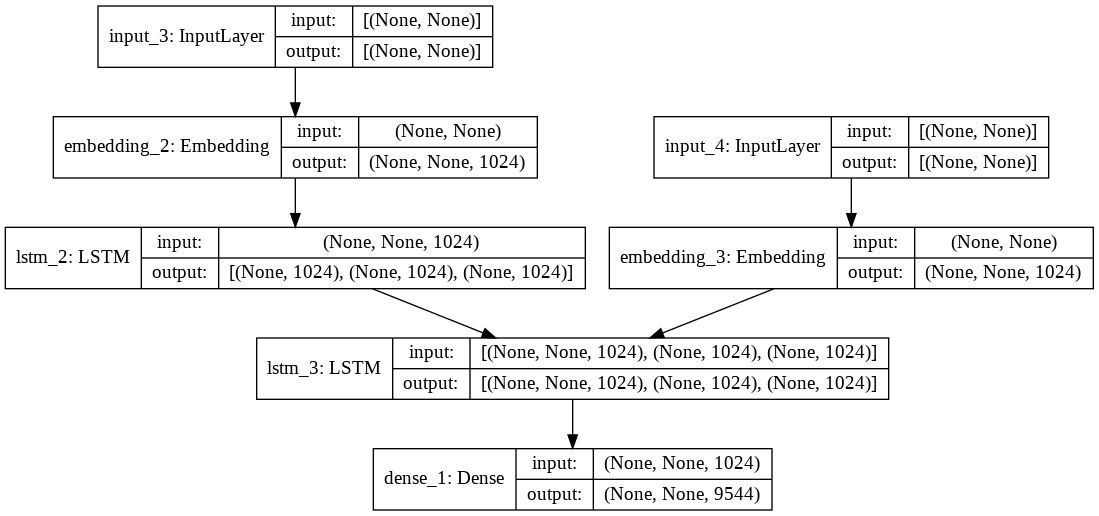

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


model.fit(x = [encoder_input_data, 
           decoder_input_data], 
          y = decoder_target_data,
          batch_size=64,
          epochs=100,
          validation_split=0.20)

Epoch 1/100
63/63 [==============================] - 15s 235ms/step - loss: 0.0730 - acc: 0.1163 - val_loss: 2.8644 - val_acc: 0.0173
Epoch 2/100
63/63 [==============================] - 15s 233ms/step - loss: 0.0710 - acc: 0.1167 - val_loss: 2.8597 - val_acc: 0.0178
Epoch 3/100
63/63 [==============================] - 15s 233ms/step - loss: 0.0686 - acc: 0.1175 - val_loss: 2.8653 - val_acc: 0.0174
Epoch 4/100
63/63 [==============================] - 15s 233ms/step - loss: 0.0670 - acc: 0.1177 - val_loss: 2.8683 - val_acc: 0.0167
Epoch 5/100
63/63 [==============================] - 15s 233ms/step - loss: 0.0649 - acc: 0.1181 - val_loss: 2.8912 - val_acc: 0.0174
Epoch 6/100
63/63 [==============================] - 15s 231ms/step - loss: 0.0628 - acc: 0.1186 - val_loss: 2.8868 - val_acc: 0.0176
Epoch 7/100
63/63 [==============================] - 15s 231ms/step - loss: 0.0605 - acc: 0.1193 - val_loss: 2.9067 - val_acc: 0.0165
Epoch 8/100
63/63 [==============================] - 15s 231ms

In [ ]:
model.save('seq2seq_en_es.h5')

In [ ]:
# define the encoder model 
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

# Redefine the decoder model with decoder will be getting below inputs from encoder while in prediction
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
final_dex2= dex(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# sampling model will take encoder states and decoder_input(seed initially) and output the predictions(french word index) We dont care about decoder_states2
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict( (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items())


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 1024)        8667136   
_________________________________________________________________
lstm_2 (LSTM)                [(None, 1024), (None, 102 8392704   
Total params: 17,059,840
Trainable params: 17,059,840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or len(decoded_sentence) > max_lenght_es):
            stop_condition = True
            # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
print('Sentencia en Inglés --> Traducción por la red Seq2Seq al Español')

 # Decodifica una por una de secuencias del conjunto de entrenamiento
for seq_index in range(35):
    
    # secuencia codificada en one-hot
    input_seq        = encoder_input_data[seq_index: seq_index + 1]
    
    # transformada por el modelo y decodificada caracter a caracter.
    decoded_sentence = decode_sequence(input_seq)
    
    # despliega resultados
    print(df.en[seq_index], ' --> ', decoded_sentence)

Sentencia en Inglés --> Traducción por la red Seq2Seq al Español
The Loner  -->   La Solitaria _END
You love curry, right?  -->   Te encanta el curry, ¿no? _END
I'll give you more.  -->   Te pondré más. _END
Hey!  -->   ¡Eh! _END
Is it good?  -->   ¿Está bueno? _END
Hey, ugly.  -->   Eh, fea. _END
Look at her.  -->   Miradla. _END
- Crazy bitch.  -->   - Puta loca. _END
- I asked you a question!  -->   - ¡Te he preguntado! _END
That's better!  -->   ¡Así estás mejor! _END
- Looking good!  -->   - ¡Estás muy guapa! _END
- That's better!  -->   - ¡Mucho mejor! _END
It suits her.  -->   Le queda bien. _END
- Hey.  -->   - Eh. _END
- What the?  -->   - ¡Idiota! _END
What the hell are you doing?  -->   ¿Qué coño haces? _END
Get out of my face, bitch.  -->   Quita de mi vista, zorra. _END
Stop picking on Ha-jung!  -->   ¡Dejad de meteros con Ha-jung! _END
What the hell?  -->   ¿Qué dices? _END
Get lost, bitch!  -->   Piérdete. _END
What?  -->   ¿Qué? _END
Stop it, Soo-na!  -->   ¡Déjala, Soo